## import & load

In [11]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [12]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

In [13]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')
    os.environ["GOOGLE_CLOUD_PROJECT"] = "trading-290017"
else:
    print('the credential.json file does not exist')

import importlib

In [14]:
import market_data.ingest.bq.cache
importlib.reload(market_data.ingest.bq.common)
importlib.reload(market_data.ingest.bq.cache)

<module 'market_data.ingest.bq.cache' from '/home/junlim/projects/jitter_recovery/market_data/ingest/bq/cache.py'>

In [15]:
date_str_from='2024-01-01'
date_str_to='2024-02-14'
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE

In [16]:
df = market_data.ingest.bq.cache.fetch_and_cache(
    dataset_mode, 
    export_mode, 
    market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from=date_str_from, date_str_to=date_str_to).reset_index()
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])

In [17]:
all_symbols = df.symbol.unique()
all_symbols = [s for s in all_symbols if s]
len([s for s in all_symbols if 'USDT' in s])

166

## calculate/cache feature

In [34]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/home/junlim/projects/jitter_recovery/algo/cache.py'>

In [19]:
feature_param = algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(30)

In [20]:
algo.jitter_recovery.research.get_feature_label_for_caching(feature_param)

'(changes)_window(30)'

In [18]:
dfst_feature = algo.cache.read_df(
    label = algo.jitter_recovery.research.get_feature_label_for_caching(feature_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-02-14', 
    date_str_to='2024-03-21')

## multiple symbols

In [30]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)

<module 'algo.jitter_recovery.research' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/research.py'>

In [31]:
trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    feature_param, 
    0.20, -0.04, 0.02, is_long_term=False)

In [32]:
algo.jitter_recovery.research.get_trading_label_for_caching(trading_param)

'(changes_trading)_feature_param(window(30))_jump_threshold(0.2)_drop_from_jump_threshold(-0.04)_exit_jumpt_threshold(0.02)_is_long_term(False)'

In [38]:
dfst_trading = algo.cache.read_df(
    label = algo.jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-01-01', 
    date_str_to='2024-03-31',
    columns=['profit', 'value', 'position_changed']
)

2024-04-19 19:07:40,408 [MainThread  ] [INFO ]  filename='/home/junlim/feature_data/(changes_trading)_feature_param(window(30))_jump_threshold(0.2)_drop_from_jump_threshold(-0.04)_exit_jumpt_threshold(0.02)_is_long_term(False)/trading-290017.market_data_okx.by_minute_2024-01-01T00:00:00-0500_2024-01-02T00:00:00-0500.parquet' does not exist.
2024-04-19 19:07:40,408 [MainThread  ] [INFO ]  df_cache is None for (datetime.datetime(2024, 1, 1, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>), datetime.datetime(2024, 1, 2, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>))


<Axes: xlabel='timestamp'>

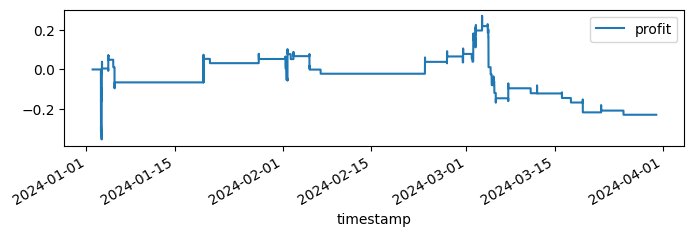

In [39]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [36]:
dfst_trading[dfst_trading.profit.fillna(0) != 0][['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
NFT-USDT-SWAP,-0.016354
FITFI-USDT-SWAP,0.010111


In [1]:
#dfst_feature.xs('FITFI-USDT-SWAP').loc['2023-12-07 16:38:00']

In [ ]:
dfst_trading[(dfst_trading.ch_max > 0.15) & (dfst_trading.ch_since_max < -0.01)]

In [ ]:
dfst_trading[(dfst_trading.ch_max > 0.15) & (dfst_trading.ch_since_max < 0)].loc[symbol_with_jumps[0]]

In [221]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-02-03 18:13:00, GAL-USDT-SWAP, 1.905, position_changed: 1.0
2024-02-03 19:18:00, GAL-USDT-SWAP, 1.852, position_changed: -1.0
2024-02-04 00:19:00, FITFI-USDT-SWAP, 0.006064, position_changed: 1.0
2024-02-04 00:31:00, FITFI-USDT-SWAP, 0.005904, position_changed: -1.0
2024-02-04 20:20:00, DMAIL-USDT-SWAP, 0.4964, position_changed: 1.0
2024-02-04 20:23:00, DMAIL-USDT-SWAP, 0.5023, position_changed: -1.0
2024-02-04 20:24:00, DMAIL-USDT-SWAP, 0.4965, position_changed: 1.0
2024-02-04 20:55:00, DMAIL-USDT-SWAP, 0.4923, position_changed: -1.0


## single symbol

In [37]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)

<module 'algo.jitter_recovery.research' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/research.py'>

In [47]:
symbol_investigate = 'AIDOGE-USDT-SWAP'
dfs = dfi.xs(symbol_investigate, level=1)

In [50]:
dfs

,open,high,low,close,volume
timestamp,,,,,
2024-03-03 05:00:00,0.0,0.0,0.0,0.0,3.422000e+13
2024-03-03 05:01:00,0.0,0.0,0.0,0.0,1.738000e+13
2024-03-03 05:02:00,0.0,0.0,0.0,0.0,3.181000e+13
2024-03-03 05:03:00,0.0,0.0,0.0,0.0,1.410000e+13
2024-03-03 05:04:00,0.0,0.0,0.0,0.0,3.950000e+12
...,...,...,...,...,...
2024-03-04 20:03:00,0.0,0.0,0.0,0.0,3.988600e+14
2024-03-04 20:04:00,0.0,0.0,0.0,0.0,1.538500e+14
2024-03-04 20:05:00,0.0,0.0,0.0,0.0,8.488000e+13


In [51]:
jitter_recovery_trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(30), 
    0.20, -0.04, 0.02, is_long_term=False)

no trading happens


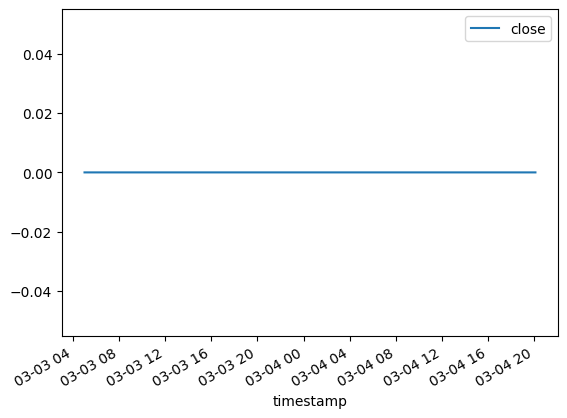

In [52]:
df_feature, df_trading = algo.jitter_recovery.research.investigate_symbol(df, symbol_investigate, jitter_recovery_trading_param, figsize=(12, 11))

In [146]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-01-03 12:27:00,1.7395,1,1.0,0.000,0.000000
2024-01-03 12:29:00,1.8060,0,-1.0,-0.016,-0.008939


In [147]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row['symbol'] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-03 12:27:00, ARB-USDT-SWAP, 1.7395, position_changed: 1.0
2024-01-03 12:28:00, ARB-USDT-SWAP, 1.79, position_changed: -1.0
